## Initial data exploration

Description: Initial data exploration and description


Describing dataset meta-info:
    1) Features
    2) Size
    

I mainly used this notebook to also get a bit familiar with folium

From User Guide of T-Drive Data we have the following description of the data:


    "This dataset contains the GPS trajectories of 10,357 taxis during the period of Feb. 2 to Feb. 8 2008 within Beijing. The total number of points in this dataset is about 15 million and the total distance of the trajectories reaches to 9 million kilometers. The average sampling interval is about 177 seconds with a distance of about 623 meters. Each file of this dataset, which is named by the taxi ID, contains the trajectories of one taxi"
    
    

In [1]:
import sys
sys.path.append("../") # Add parent dir to source
import pandas as pd
import numpy as np

import folium
from folium import plugins
from folium.plugins import HeatMap
import datetime

In [2]:
taxi_df = pd.read_pickle("../processed_data/taxi_data.pkl")

In [3]:
# Number of measurements
taxi_df.shape

(17662984, 4)

In [4]:
taxi_df.head()

taxi_id                time       long       lat
0     1607 2008-02-02 13:35:55  116.41522  39.90718
1     1607 2008-02-02 13:40:55  116.41175  39.90717
2     1607 2008-02-02 13:45:55  116.39756  39.90656
3     1607 2008-02-02 13:50:55  116.37864  39.90600
4     1607 2008-02-02 13:55:55  116.36032  39.90601

In [5]:
# Distribution of dates of measurements

# Measurements per taxi
# Plot path of one taxi through history.

In [6]:
import matplotlib.pyplot as plt

In [7]:
len(taxi_df["taxi_id"].unique())

10336

### Data
10357 files in folder, but 10337 unique ids. Why are some missing?

Find taxi ids, which are folder, but not in dataframe:

In [8]:
ids = [i+1 for i in range(10357)]
set(ids).difference(set(taxi_df["taxi_id"].unique()))

{295,
 1089,
 1497,
 1947,
 2929,
 2945,
 3050,
 3160,
 3194,
 3950,
 5972,
 6030,
 6236,
 6322,
 6717,
 7583,
 8209,
 8424,
 9874,
 10115,
 10352}

When going through the files with corresponding ids I found that all of them were empty. Therefore there are 10336 unique relevant taxi.

In [9]:
# Number of measurements
len(taxi_df)

17662984

There are 17 million measurements in the dataset. On average there are 1708 measurements per taxi, with standard deviation of 4733.. This is quite a big deviation.

In [10]:
measurements_per_taxi = taxi_df.groupby("taxi_id").size()

In [11]:
measurements_per_taxi.values

array([ 588, 1674, 1371, ...,  379,  526,  734])

In [12]:
measurements_per_taxi.values.mean()

1708.8800309597523

In [13]:
measurements_per_taxi.values.std()

4733.5821021634

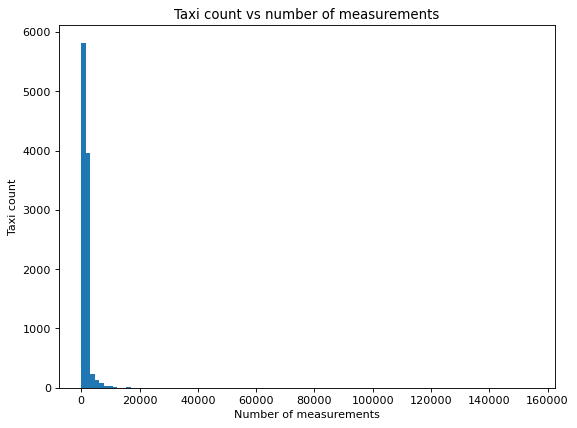

In [14]:

plt.figure(figsize=(8, 6), dpi=80)
plt.hist(measurements_per_taxi.values, bins=100)
plt.xlabel("Number of measurements")
plt.ylabel("Taxi count")
plt.title("Taxi count vs number of measurements")
plt.show()

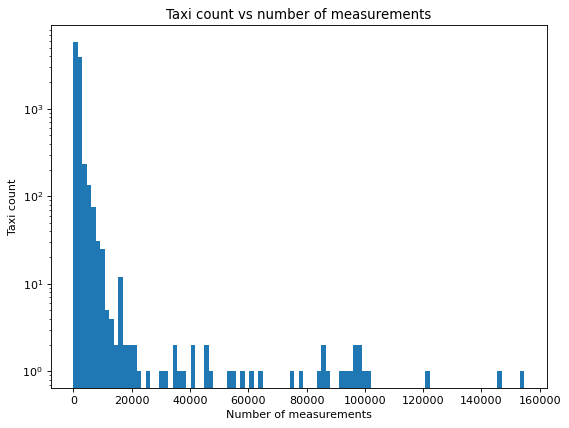

In [15]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(measurements_per_taxi.values, bins=100)
plt.yscale("log")
plt.xlabel("Number of measurements")
plt.ylabel("Taxi count")
plt.title("Taxi count vs number of measurements")
plt.show()

We can see that most of the taxi have less than 20k measurements. 
Out of 10336 taxi with measurmenets, 10298 have less than 20000 measurements. 38 taxi have more than 20k measurements.

In [16]:
np.sum(measurements_per_taxi <= 20000)


10298

In [17]:
len(measurements_per_taxi)

10336

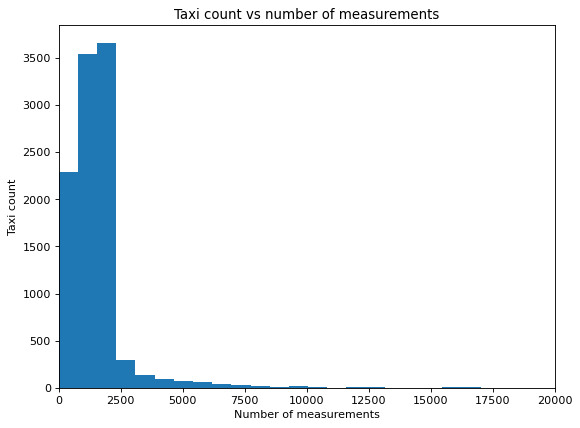

In [18]:
# Keep only measurements which are less than 20k

plt.figure(figsize=(8, 6), dpi=80)
plt.xlim(0, 20000)
plt.hist(measurements_per_taxi.values, bins=200)
plt.xlabel("Number of measurements")
plt.ylabel("Taxi count")
plt.title("Taxi count vs number of measurements")
plt.show()

In [19]:
np.sum(measurements_per_taxi < 2500)

9586

As a matter of fact, most of the taxi have less than 2500 measurements.

In [20]:
taxi_df.groupby("taxi_id").count().sort_values("time", ascending=False).head()

time    long     lat
taxi_id                        
6275     154688  154688  154688
3015     145812  145812  145812
3557     121667  121667  121667
3579     101843  101843  101843
366       99494   99494   99494

4 taxi have more than 100k measurements. The taxi with most measurements has id 6275. 

Looking at taxi 6275, it seems that it is non-stop always moving. And it has super high sampling frequency - almost every second - many longitudes and latitudes are replicates.

### Folium test

In [24]:
import folium

In [25]:
# Keep taxis with less than 2500 measurements
counts = taxi_df.groupby("taxi_id").count().reset_index()

In [26]:
taxi_id_under_2500_measurements = counts[counts["time"] <= 2500]["taxi_id"]

In [27]:
filtered_taxi_df = taxi_df[taxi_df.taxi_id.isin(taxi_id_under_2500_measurements.index)]

In [28]:
filtered_taxi_df

taxi_id                time       long       lat
0       1607 2008-02-02 13:35:55  116.41522  39.90718
1       1607 2008-02-02 13:40:55  116.41175  39.90717
2       1607 2008-02-02 13:45:55  116.39756  39.90656
3       1607 2008-02-02 13:50:55  116.37864  39.90600
4       1607 2008-02-02 13:55:55  116.36032  39.90601
..       ...                 ...        ...       ...
699     5020 2008-02-08 13:27:37  116.15851  39.87433
700     5020 2008-02-08 13:27:37  116.15851  39.87433
701     5020 2008-02-08 13:27:37  116.15851  39.87433
702     5020 2008-02-08 13:27:37  116.15851  39.87433
703     5020 2008-02-08 13:27:37  116.15851  39.87433

[16248462 rows x 4 columns]

### Get 3rd february data


In [29]:
third_feb_df = filtered_taxi_df[filtered_taxi_df["time"].dt.day == 3]

In [31]:
### Plot time distribution of measurements

In [32]:
len(third_feb_df["taxi_id"].unique())


9209

In [33]:
## Duplicates

Duplicate measurements:


    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435
    5020,2008-02-03 18:05:55,116.15852,39.87435


In [34]:
# Drop duplicates, where everything is same. Keep first measurement.
duplicates_dropped = third_feb_df.drop_duplicates(keep="first")

In [35]:
duplicates_dropped

taxi_id                time       long       lat
121     1607 2008-02-03 00:00:53  116.42565  39.85742
122     1607 2008-02-03 00:05:53  116.37732  39.85714
123     1607 2008-02-03 00:10:53  116.38140  39.87679
124     1607 2008-02-03 00:20:53  116.38369  39.88287
125     1607 2008-02-03 00:25:53  116.36824  39.88804
..       ...                 ...        ...       ...
171     5020 2008-02-03 15:46:07  116.16094  39.87593
172     5020 2008-02-03 15:52:05  116.16089  39.87599
193     5020 2008-02-03 17:56:56  116.16146  39.87236
195     5020 2008-02-03 18:00:49  116.15850  39.87439
196     5020 2008-02-03 18:05:55  116.15852  39.87435

[2627909 rows x 4 columns]

In [36]:
# Look at some taxi examples
taxi_1607 = duplicates_dropped[duplicates_dropped["taxi_id"] == 1607]
taxi_5020 = duplicates_dropped[duplicates_dropped["taxi_id"] == 5020]

In [37]:
taxi_1607

taxi_id                time       long       lat
121     1607 2008-02-03 00:00:53  116.42565  39.85742
122     1607 2008-02-03 00:05:53  116.37732  39.85714
123     1607 2008-02-03 00:10:53  116.38140  39.87679
124     1607 2008-02-03 00:20:53  116.38369  39.88287
125     1607 2008-02-03 00:25:53  116.36824  39.88804
..       ...                 ...        ...       ...
339     1607 2008-02-03 22:49:39  116.43898  39.89726
340     1607 2008-02-03 22:54:39  116.43801  39.89616
341     1607 2008-02-03 22:59:39  116.43452  39.90477
342     1607 2008-02-03 23:09:39  116.45334  39.90727
343     1607 2008-02-03 23:14:39  116.45519  39.90847

[214 rows x 4 columns]

### Visualising lats and longs of a couple taxi on Tuesday

In [39]:


#m = folium.Map(location=[39.907, 116.438], zoom_start=10, tiles="Stamen Toner")
m = folium.Map(location=[39.907, 116.438], zoom_start=10)

locs_1 = list(zip(taxi_1607["lat"], taxi_1607["long"]))
locs_2 = list(zip(taxi_5020["lat"], taxi_5020["long"]))

# Adding trajectories to the map
folium.PolyLine(locations=locs_1, color='darkred', no_clip=True).add_to(m)
folium.PolyLine(locations=locs_2, color='darkblue', no_clip=True).add_to(m)
m

## Heatmaps and points 

Testing out Folium's features.

In [41]:
duplicates_dropped["time"].dt.time

121    00:00:53
122    00:05:53
123    00:10:53
124    00:20:53
125    00:25:53
         ...   
171    15:46:07
172    15:52:05
193    17:56:56
195    18:00:49
196    18:05:55
Name: time, Length: 2627909, dtype: object

In [42]:
# For each taxi keep first point after midday


first_afternoon = duplicates_dropped[duplicates_dropped["time"].dt.time >= datetime.time(20, 0, 0)]
first_in_grp = first_afternoon.groupby("taxi_id").first()

filter_too_late = first_in_grp[first_in_grp["time"].dt.time <= datetime.time(20,30,0)]

#duplicates_dropped[duplicates_dropped[""]]

In [43]:
filter_too_late

time       long       lat
taxi_id                                         
1       2008-02-03 20:05:14  116.69155  39.85164
2       2008-02-03 20:00:38  116.30070  39.88048
3       2008-02-03 20:03:58  116.42616  39.93185
6       2008-02-03 20:00:55  116.34408  39.93843
10      2008-02-03 20:02:17  116.45593  39.93297
...                     ...        ...       ...
10330   2008-02-03 20:12:13  116.43192  39.86313
10331   2008-02-03 20:01:29  116.47588  39.91596
10333   2008-02-03 20:02:49  116.41428  39.80642
10334   2008-02-03 20:02:32  116.35198  40.08145
10335   2008-02-03 20:04:32  116.33428  39.91289

[7786 rows x 3 columns]

In [44]:
## Points

m_points = folium.Map(location=[39.907, 116.438], zoom_start=10, tiles="Stamen Toner")


for id_, row in filter_too_late.iterrows():
    
    folium.CircleMarker(
        location=[row["lat"], row["long"]],
        radius=1,
        #popup="Laurelhurst Park",
        color="#3186cc",
        fill=False,
        fill_color="#3186cc",
    ).add_to(m_points)


m_points

In [45]:
heats = list(zip(filter_too_late["lat"], filter_too_late["long"]))

In [46]:

m_heat = folium.Map(location=[39.907, 116.438], zoom_start=10)

HeatMap(heats).add_to(m_heat)

m_heat

## Conclusions


In total there are 17 million measurements.

There were some taxies with no measurements logged at all. Most of the taxies have less than 2500 measurements, however there are some  with over 100k measurements. The sampling frequency varies a lot.

There are replicates in measurements, even with exact same timestamp - this is most likely due to connectivity problems of devices, which makes it send same data multiple times as it had not received confirmation that previously sent data was received.

We can see that there are GPS locations which are way out of Beijing. Some not even on the same continent. Most of the data is indeed in Beijing and mostly within the 5th Ring.